In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import math
from heateq import Exact, Simulateur
import time

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

# Description des simulateurs

On considère l'équation de la chaleur unidimensionnelle vue en cours, et la même distribution de probabilité pour $\mathbf{X}$.
On rappelle que la précision de $\tilde{h}^{(K,Q)}$ est gouvernée par les entiers $K$ et $Q$, et que le coût moyen d'évaluer $\tilde{h}^{(K,Q)}(\mathbf{X})$ est proportionnel à $KQ$.

On définit un simulateur haute fidélité $f = \tilde{h}^{(K=21,Q=60)}$ et un simulateur basse fidélité $g = \tilde{h}^{(K=3,Q=15)}$.

On note $w = c_g / c_f$, où $c_f$ (respectivement, $c_g$) est le coût moyen d'évaluer $f(\mathbf{X})$ (respectivement, $g(\mathbf{X})$).

Dans la suite, on note $Y=f(\mathbf{X})$ et $Z=g(\mathbf{X})$.

**Question 1** : Quelle est la valeur attendue de $w$ ? Le vérifier expérimentalement.

On trouve w = 1/28 = 0.03571

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 60)
g = Simulateur(3, 15)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu

In [36]:
ns = 10000
X = n_echantillon_X(ns) 
X.shape


(7, 10000)

In [37]:
t1_start = time.process_time()  
f(X)
t1_stop = time.process_time() 
print("Elapsed time of f in seconds:", t1_stop-t1_start)  


Elapsed time of f in seconds: 0.1783090610000002


In [38]:
t2_start = time.process_time()  
g(X)
t2_stop = time.process_time() 
print("Elapsed time of g in seconds:", t2_stop-t2_start)  

Elapsed time of g in seconds: 0.005948142000001155


In [39]:
w = (t2_stop-t2_start)/ (t1_stop-t1_start)
w

0.033358607614456276

# Estimateur ACV-IS

On définit deux échantillons *indépendants* (c'est-à-dire que leurs membres sont mutuellement indépendants)
$$\mathcal{X} = \{\mathbf{X}_1, \ldots, \mathbf{X}_n\} \quad \text{ et } \quad \mathcal{X}' = \{\mathbf{X}_1', \ldots, \mathbf{X}_N'\}$$
et l'estimateur par variable de contrôle approchée ACV-IS (IS pour *independent sampling*) par
$$\bar{Y}_{n,N}^{\textnormal{acv-is}}(\alpha) = \bar{Y}_n - \alpha(\bar{Z}_n - \bar{Z}_N')$$
où
* $\bar{Y}_n = \frac{1}{n} \sum\limits_{i=1}^n f(\mathbf{X}_i)$,
* $\bar{Z}_n = \frac{1}{n} \sum\limits_{i=1}^n g(\mathbf{X}_i)$,
* $\bar{Z}_N' = \frac{1}{N} \sum\limits_{i=1}^N g(\mathbf{X}_i')$.

**Question 2** : Montrer que le coût moyen d'évaluation de $\bar{Y}_{n,N}^{\textnormal{acv-is}}(\alpha)$ est
$$c=n(c_f + \tau c_g)$$
où $\tau = 1 + \dfrac{N}{n}$.

**Question 3** : En déduire le nombre d'évaluations haute fidélité équivalentes $\tilde{n}_f = c / c_f$, exprimée en fonction de $\tau$ et $w$.

**Question 4** : Montrer que
$$\mathbb{C}[\bar{Y}_n, \bar{Z}_n - \bar{Z}_N'] = \dfrac{1}{n}\mathbb{C}[Y, Z] \quad 
\text{ et } \quad 
\mathbb{V}[\bar{Z}_n - \bar{Z}_N'] = \dfrac{n+N}{nN} \mathbb{V}[Z].$$

**Question 5** : En déduire que la valeur de $\alpha$ qui minimise $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{acv-is}}(\alpha)]$, notée $\alpha^*$, est
$$\alpha^*=\dfrac{N}{n+N} \dfrac{\mathbb{C}[Y, Z]}{\mathbb{V}[Z]}$$
et que la variance minimale est alors
$$\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{acv-is}}(\alpha^*)] 
= \mathbb{V}[\bar{Y}_{\tilde{n}_f}](1+\tau w)\left(1 - \dfrac{N}{n+N} \rho^2 \right)$$
où $\bar{Y}_{\tilde{n}_f} = \displaystyle\frac{1}{\tilde{n}_f} \sum\limits_{i=1}^{\tilde{n}_f} f(\mathbf{X}_i)$ et $\rho$ est le coefficient de corrélation de Pearson entre $Y$ et $Z$.

**Question 6** : Montrer que $\dfrac{N}{n+N} = 1 - \dfrac{1}{\tau}$ et comparer l'expression de $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{acv-is}}(\alpha^*)]$ à celle de $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{acv}}(\alpha^*)]$ vue en cours. 
En déduire que la valeur de $\tau$ qui minimise $\mathbb{V}[\bar{Y}_{n,N}^{\textnormal{acv-is}}(\alpha^*)]$, notée $\tau^*$, est
$$\tau^* = \sqrt{\dfrac{\rho^2}{w(1-\rho^2)}}$$
et que, pour un budget $\tilde{n}_f$ donné, l'estimateur ACV-IS optimal est
$$\bar{Y}_{n^*,N^*}^{\textnormal{acv-is}}(\alpha^*) = \bar{Y}_{n^*} - \alpha^*(\bar{Z}_{n^*} - \bar{Z}_{N^*}')$$
où $\alpha^* = \left(1 - \dfrac{1}{\tau^*}\right) \dfrac{\mathbb{C}[Y, Z]}{\mathbb{V}[Z]}$,
$n^* = \dfrac{\tilde{n}_f}{1 + \tau^* w}$ et $N^* = (\tau^* - 1)n^*$.

**Question 7** : Déduire du cours que
$$\beta = \dfrac{\mathbb{V}[\bar{Y}_{n^*,N^*}^{\textnormal{acv-is}}(\alpha^*)]}{\mathbb{V}[\bar{Y}_{\tilde{n}_f}]}
= (1+\tau^* w)^2 (1 - \rho^2).$$

Quelles conclusions pouvez-vous tirer sur les estimateurs ACV et ACV-IS optimaux ?

# Expérience pilote

**Question 8** : Estimer $\rho^2$ et $\tau^*$ à l'aide de `ns = 10000` échantillons pilotes.

**Question 9** : En déduire une estimation de $\alpha^*=\left(1 - \dfrac{1}{\tau^*}\right) \dfrac{\mathbb{C}[Y, Z]}{\mathbb{V}[Z]}$ et de $\beta=(1+\tau^* w)^2(1-\rho^2)$.

In [42]:
ns = 10000 # échantillons pilotes
X = n_echantillon_X(ns)

In [43]:
# Q8
Y = f(X)
Z = g(X)
cov_Y_Z = np.cov(Y, Z)
rho_2 = cov_Y_Z[0, 1]**2 / (cov_Y_Z[0, 0] * cov_Y_Z[1, 1])
tau = np.sqrt(rho_2 / (w * (1 - rho_2)))

print(f"Estimation rho^2 = {rho_2}")
print(f"Estimation tau = {tau}")

# Q9
beta = (1 + tau*w)**2 * (1 - rho_2)
alpha = (1 - (1/tau))*cov_Y_Z[0, 1] / cov_Y_Z[1, 1]

print(f"Estimation beta = {beta}")
print(f"Estimation alpha = {alpha}")

Estimation rho^2 = 0.9806960132863617
Estimation tau = 39.02471521417729
Estimation beta = 0.10227889235546689
Estimation alpha = 0.9815975374739797


# Analyse de l'estimateur ACV-IS

**Question 10** : Utiliser la valeur de $\alpha^*$ estimée précédemment (avec les échantillons pilotes) pour contruire un estimateur ACV-IS de l'espérance de $Y$.
Faire `nr = 1000` répétitions pour des budgets (en termes de nombre d'évaluations haute fidélité équivalentes) $\tilde{n}_f = c / c_f \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

**Question 11** : Pour chaque budget, estimer le rapport de variance $\beta$ à budget équivalent entre l'estimateur ACV-IS et l'estimateur Monte Carlo classique (haute fidélité). Ces estimations sont-elles conformes à la valeur de $\beta$ estimée précédemment (dans l'expérience pilote) ?

**Question 12** : Tracer l'espérance et l'écart-type (sous forme de barres d'erreur) des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}_f$.
Sur un autre graphe (en échelle log-log), tracer l'évolution de la REQM (par rapport à l'espérance exacte du problème continu, `mu_exact`) des estimateurs en fonction de $\tilde{n}_f$.

In [47]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

mean_Y_nf_par_budget = []
mean_Y_n_N_acv__par_budget = []
std_Y_nf_par_budget = []
std_Y_n_N_acv__par_budget = []
REQM_Y_nf = []
REQM_Y_n_N_acv = []
beta_par_budget = []
for nf in budgets :
    # n et N pour budget équivalent
    n = int(nf / (1 + tau * w))
    N = int(tau * n)
    print(f"Budget = {nf} - n = {n} - N = {N}")

    Y_nf_mc = np.zeros(nr)
    Y_n_N_acv_mc = np.zeros(nr)
    REQM_Y_nf_mc = np.zeros(nr)
    REQM_Y_n_N_acv_mc = np.zeros(nr)
    for i in range(nr) :
        X = n_echantillon_X(N)
        
        # Calcul des variables avec le bon nombre d'échantillon
        Y_nf = f(X[:, :nf])
        Y_n = Y_nf[:n]
        Z_N = g(X)
        Z_n = Z_N[:n]
        
        # Calcul de la variable de contrôle
        Y_n_N_acv = Y_n.mean() - alpha * (Z_n.mean() - Z_N.mean())

        Y_nf_barre = Y_nf.mean()
        Y_nf_mc[i] = Y_nf_barre
        Y_n_N_acv_mc[i] = Y_n_N_acv

        # Calcul de la REQM
        REQM_Y_nf_mc[i] = np.sqrt((Y_nf_barre - mu_exact)**2)
        REQM_Y_n_N_acv_mc[i] = np.sqrt((Y_n_N_acv - mu_exact)**2)

        
    mean_Y_nf_par_budget.append(Y_nf_mc.mean())
    mean_Y_n_N_acv__par_budget.append(Y_n_N_acv_mc.mean())
    std_Y_nf_par_budget.append(Y_nf_mc.std())
    std_Y_n_N_acv__par_budget.append(Y_n_N_acv_mc.std())
    REQM_Y_nf.append(REQM_Y_nf_mc.mean())
    REQM_Y_n_N_acv.append(REQM_Y_n_N_acv_mc.mean())

    beta_par_budget.append(Y_n_N_acv_mc.std() / Y_nf_mc.std())

    




Budget = 5 - n = 2 - N = 78
Budget = 10 - n = 4 - N = 156
Budget = 20 - n = 8 - N = 312
Budget = 50 - n = 21 - N = 819
Budget = 100 - n = 43 - N = 1678
Budget = 200 - n = 86 - N = 3356
Budget = 500 - n = 217 - N = 8468
Budget = 1000 - n = 434 - N = 16936


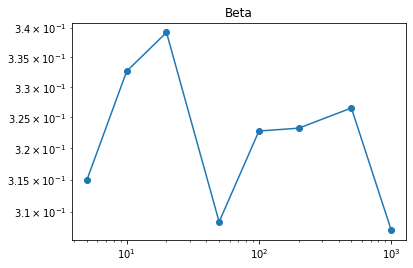

In [50]:
import matplotlib.pyplot as plt

plt.loglog(budgets, beta_par_budget, marker="o")
plt.title("Beta")

plt.show()

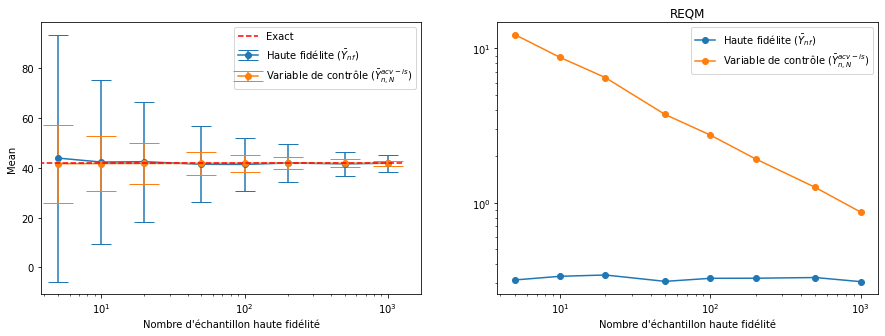

In [52]:
label_hf = 'Haute fidélite ($\\bar{Y}_{nf}$)'
label_acv = 'Variable de contrôle ($\\bar{Y}_{n,N}^{acv-is}$)'
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(budgets, mean_Y_nf_par_budget, yerr=std_Y_nf_par_budget, label=label_hf, marker='o',capsize=10)
plt.errorbar(budgets, mean_Y_n_N_acv__par_budget, yerr=std_Y_n_N_acv__par_budget, label=label_acv, marker='o',capsize=15)
plt.hlines(mu_exact, 0, budgets[-1]+300, colors="red", linestyles="--", zorder=10, label="Exact")
plt.xlabel("Nombre d'échantillon haute fidélité")
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("REQM")
plt.loglog(budgets, beta_par_budget, marker="o", label=label_hf)
plt.loglog(budgets, REQM_Y_n_N_acv, marker="o", label=label_acv)
plt.xlabel("Nombre d'échantillon haute fidélité")
plt.legend()
plt.show()